In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['annotation', 'all-dogs']


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm_notebook as tqdm

In [3]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )


    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        out = self.model(imgs)
        return out.view(-1, 1)

In [4]:
batch_size = 32
lr = 0.0005
beta1 = 0.5
epochs = 200

real_label = 0.5
fake_label = 0
#real_label = 1
#fake_label = -1
nz = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

In [6]:
class ParamScheduler(object):
    
    def __init__(self, optimizer, scale_fn, step_size):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        
        self.optimizer = optimizer
        self.scale_fn = scale_fn
        self.step_size = step_size
        self.last_batch_iteration = 0
        
    def batch_step(self):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.scale_fn(self.last_batch_iteration / self.step_size)
        
        self.last_batch_iteration += 1


def combine_scale_functions(scale_fns, phases=None):
    if phases is None:
        phases = [1. / len(scale_fns)] * len(scale_fns)
    phases = [phase / sum(phases) for phase in phases]
    phases = torch.tensor([0] + phases)
    phases = torch.cumsum(phases, 0)
    
    def _inner(x):
        idx = (x >= phases).nonzero().max()
        actual_x = (x - phases[idx]) / (phases[idx + 1] - phases[idx])
        return scale_fns[idx](actual_x)
        
    return _inner


def scale_cos(start, end, x):
    return start + (1 + np.cos(np.pi * (1 - x))) * (end - start) / 2

In [7]:
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
random_transforms = [transforms.RandomRotation(degrees=5)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = DogDataset(img_dir='../input/all-dogs/all-dogs/',
                           transform1=transform1,
                           transform2=transform2)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

                                           
imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

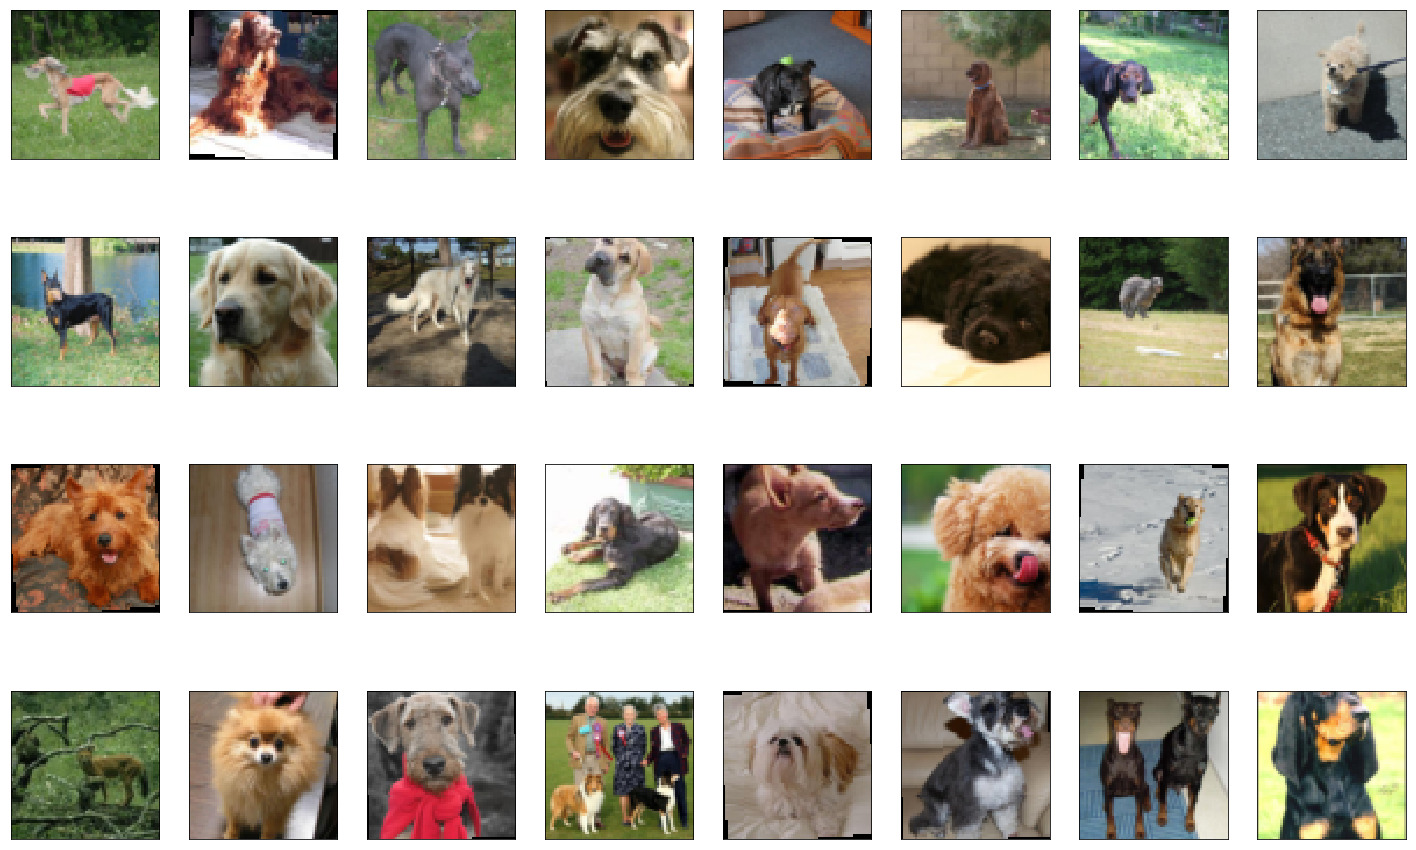

In [8]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(imgs):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    
    plt.imshow((img+1)/2)

In [9]:
from functools import partial
from torch.optim.optimizer import Optimizer

netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

#optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
#optimizerG = optim.RMSprop(netG.parameters(), lr=lr)



scale_fn = combine_scale_functions(
    [partial(scale_cos, 1e-5, 5e-4), partial(scale_cos, 5e-4, 1e-4)], [0.2, 0.8])

#optimizer_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizer_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))

scheduler_g = ParamScheduler(optimizerG, scale_fn, epochs * len(train_loader))
scheduler_d = ParamScheduler(optimizerD, scale_fn, epochs * len(train_loader))

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

In [10]:
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    plt.imshow((gen_image+1)/2)    

    plt.show()

[1/200][322/644] Loss_D: 0.6762 Loss_G: 0.1719
[1/200][644/644] Loss_D: 1.0773 Loss_G: 0.1002



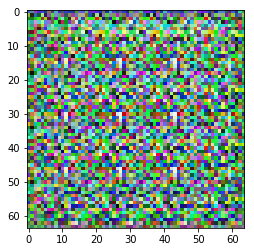

[2/200][322/644] Loss_D: 0.2740 Loss_G: 0.5114
[2/200][644/644] Loss_D: 0.1836 Loss_G: 1.4361



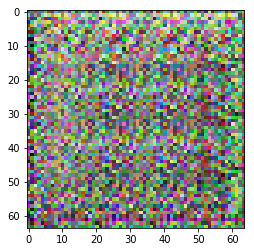

[3/200][322/644] Loss_D: 0.0963 Loss_G: 0.8475
[3/200][644/644] Loss_D: 0.0975 Loss_G: 1.5312



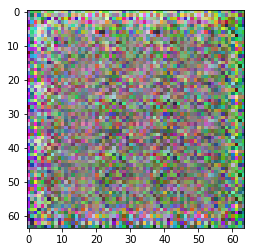

[4/200][322/644] Loss_D: 0.0424 Loss_G: 0.8310
[4/200][644/644] Loss_D: 0.1281 Loss_G: 0.5367



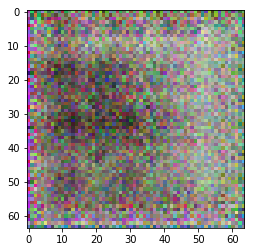

[5/200][322/644] Loss_D: 0.0890 Loss_G: 0.7386
[5/200][644/644] Loss_D: 0.2004 Loss_G: 0.3786



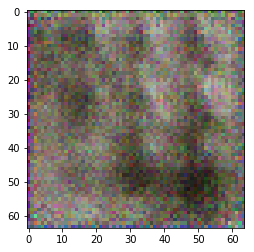

[6/200][322/644] Loss_D: 0.3323 Loss_G: 0.2329
[6/200][644/644] Loss_D: 0.3433 Loss_G: 0.2638



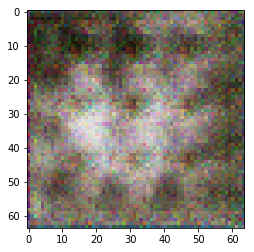

[7/200][322/644] Loss_D: 0.2517 Loss_G: 0.2922
[7/200][644/644] Loss_D: 0.1845 Loss_G: 0.4564



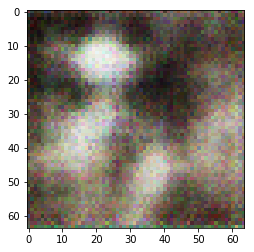

[8/200][322/644] Loss_D: 0.2092 Loss_G: 0.3998
[8/200][644/644] Loss_D: 0.0811 Loss_G: 0.8425



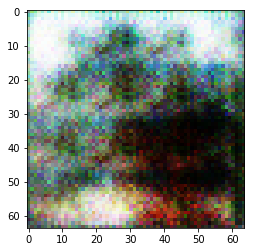

[9/200][322/644] Loss_D: 0.3288 Loss_G: 0.2474
[9/200][644/644] Loss_D: 0.3119 Loss_G: 0.3169



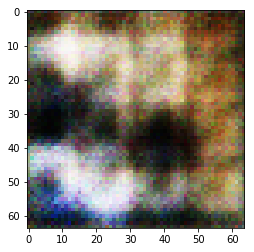

[10/200][322/644] Loss_D: 0.1662 Loss_G: 0.4911
[10/200][644/644] Loss_D: 0.1091 Loss_G: 0.6920



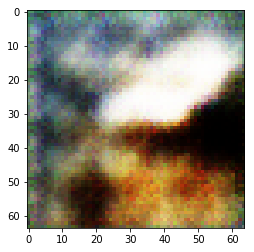

[11/200][322/644] Loss_D: 0.0701 Loss_G: 1.0820
[11/200][644/644] Loss_D: 0.1101 Loss_G: 1.1570



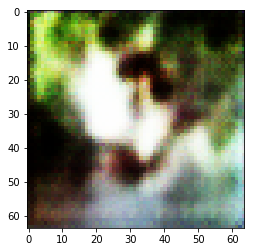

[12/200][322/644] Loss_D: 0.2379 Loss_G: 0.6154
[12/200][644/644] Loss_D: 0.2733 Loss_G: 0.9106



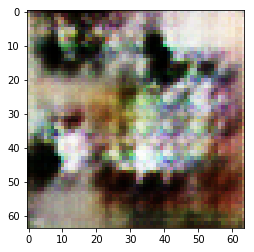

[13/200][322/644] Loss_D: 0.2147 Loss_G: 0.4764
[13/200][644/644] Loss_D: 0.0392 Loss_G: 1.4034



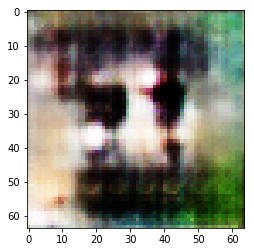

[14/200][322/644] Loss_D: 0.1021 Loss_G: 1.0958
[14/200][644/644] Loss_D: 0.4398 Loss_G: 2.4083



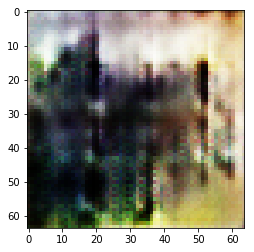

[15/200][322/644] Loss_D: 0.1505 Loss_G: 0.6726
[15/200][644/644] Loss_D: 0.4602 Loss_G: 3.4152



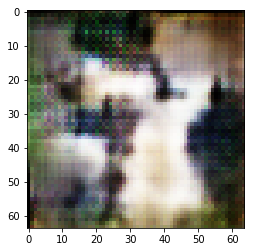

[16/200][322/644] Loss_D: 0.2256 Loss_G: 0.5325
[16/200][644/644] Loss_D: 0.0563 Loss_G: 1.4154



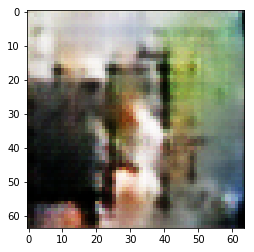

[17/200][322/644] Loss_D: 0.1523 Loss_G: 0.7252
[17/200][644/644] Loss_D: 0.4906 Loss_G: 4.1651



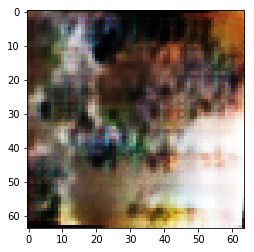

[18/200][322/644] Loss_D: 0.0935 Loss_G: 1.0057
[18/200][644/644] Loss_D: 0.0756 Loss_G: 1.6996



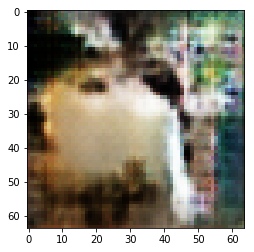

In [11]:
# WGAN
'''    

g_loss = []
d_loss = []

for epoch in range(epochs):
    
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        for _ in range(5):
            
            ############################
            # (1) Update D network
            ###########################
            netD.zero_grad()
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            labels = torch.full((batch_size, 1), real_label, device=device)
            outputR = netD(real_images)
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            outputF = netD(fake.detach())
            #errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
            #        torch.mean((outputF - torch.mean(outputR) + labels) ** 2))/2
            errD = -(torch.mean(outputR) - torch.mean(outputF))
            errD.backward(retain_graph=True)
            optimizerD.step()
            # Weight clipping
            for p in netD.parameters():
                p.data.clamp_(-0.01, 0.01)
                
            netD.zero_grad()
            netG.zero_grad()
            
            
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        outputF = netD(fake)   
        #errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
        #        torch.mean((outputF - torch.mean(outputR) - labels) ** 2))/2
        errG = -torch.mean(outputF)
        errG.backward()
        optimizerG.step()
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item()))
            
        g_loss.append(errG.item())
        d_loss.append(errD.item())

    show_generated_img()
'''
    
'''
    RaLSGAN
'''
    
g_loss = []
d_loss = []
g_lr = []
d_lr = []

for epoch in range(epochs):
    
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        scheduler_d.batch_step()
        
        outputR = netD(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        outputF = netD(fake.detach())
        errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
                torch.mean((outputF - torch.mean(outputR) + labels) ** 2))/2
        errD.backward(retain_graph=True)
        optimizerD.step()
        
        for param_group in optimizerD.param_groups:
            d_lr.append(param_group['lr'].item())
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        scheduler_g.batch_step()
        outputF = netD(fake)   
        errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
                torch.mean((outputF - torch.mean(outputR) - labels) ** 2))/2
        errG.backward()
        optimizerG.step()
        
        for param_group in optimizerG.param_groups:
            g_lr.append(param_group['lr'].item())
        
        
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item()))
            
        g_loss.append(errG.item())
        d_loss.append(errD.item())

    show_generated_img()

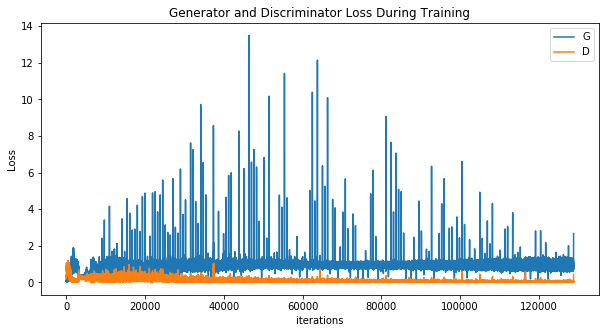

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss,label="G")
plt.plot(d_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

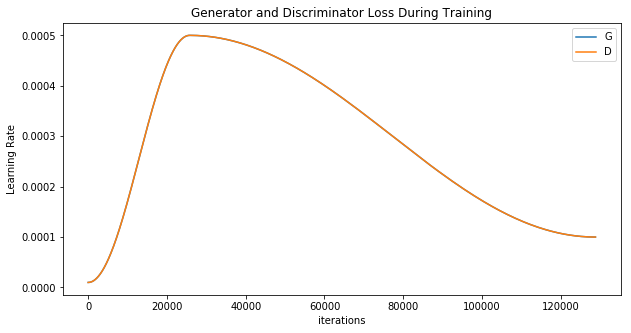

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_lr,label="G")
plt.plot(d_lr,label="D")
plt.xlabel("iterations")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()

In [14]:
batch_size = 32
gen_z = torch.randn(batch_size, nz, 1, 1, device=device)
gen_images = (netG(gen_z).to("cpu").clone().detach() + 1)/2
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)

In [15]:
batch_size

32

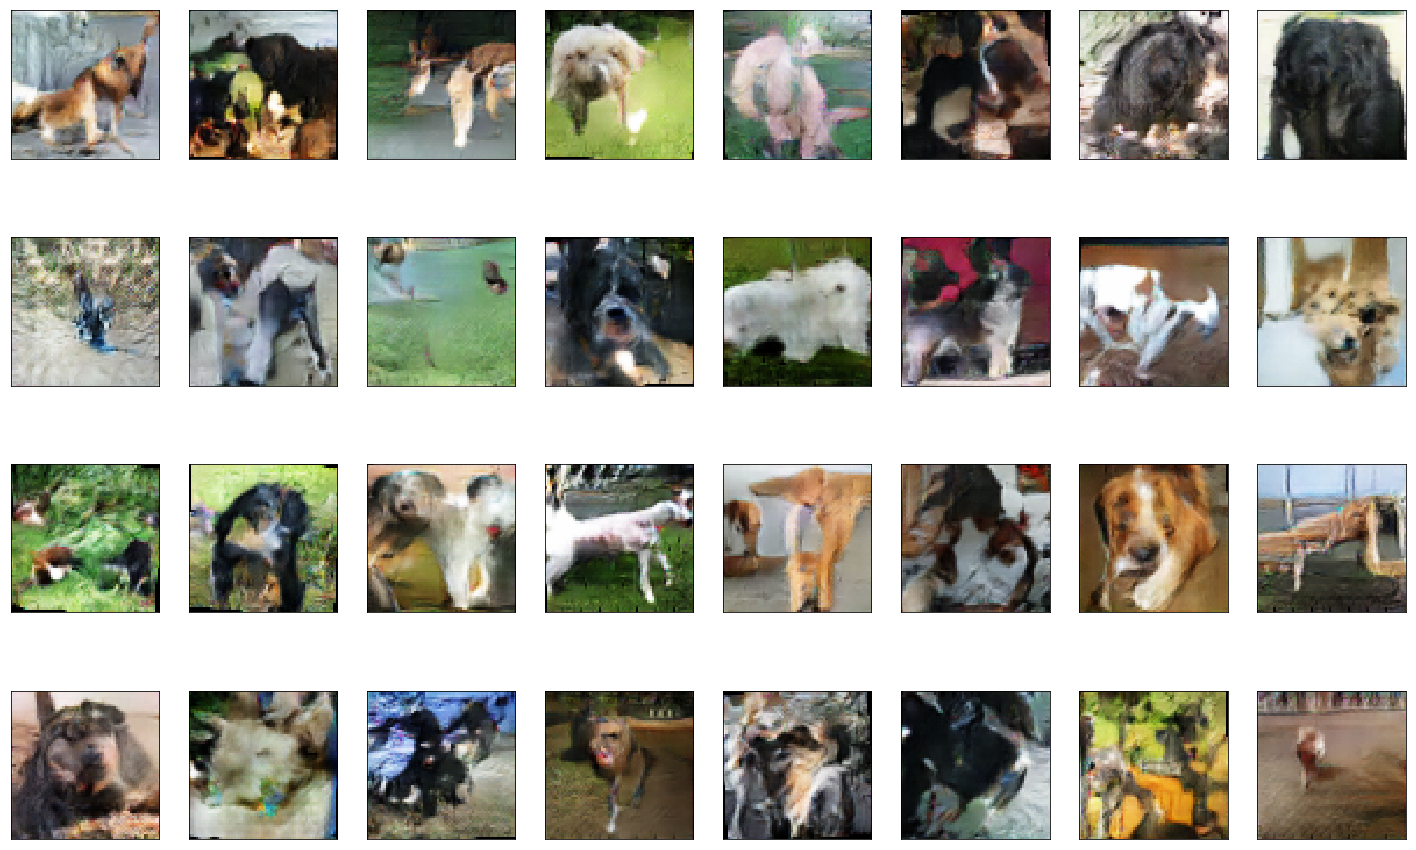

In [16]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(gen_images):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow(img)

In [17]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = (netG(gen_z) + 1)/2
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

### Latent Vector

In [18]:
gen_z.size()

torch.Size([50, 512, 1, 1])

In [19]:
gen_z[0][0].item()

0.12768767774105072

In [20]:
nz

512